# Generate users arrivals

Currently our paper work defines the arrivals of users as a function dependant on the price they pay $\rho$

$$\rho = (1+P)p \tag{1}$$

with $P\in [0,1]$ being the marginal benefit, and $p\in [m,M]$ the spot price.

[16] suggests to use a function like

$$ f(p_{norm}) = k(1-p_{norm}^a)^b,\quad p_{norm}\in[0,1] \tag{2}$$

to derive the arrivals of users asking for an instance, based on the normalized AWS spot price $p_{norm}$. Following its idea, we replace $x$ with the price the user pays $\rho$. And define:

$$ f(\rho) = \frac{k}{1 + \frac{\rho - m}{2M-m}} \left( 1 - \left(\frac{\rho}{2M}\right)^a \right)^b \tag{3} $$

see the plot below to check how does it work.

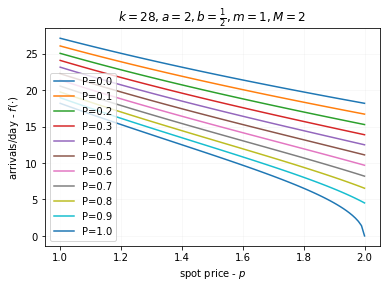

In [102]:
import matplotlib.pyplot as plt

def f(p, P, k, a=2, b=0.5, m=1, M=2):
    rho = (1+P)*p
    if rho/(2*M) > 1 or p > M:
        return 0
    return k / (1 + (rho-m)/(2*M-m)) * (1 - (rho/(2*M))**a)**b

# Plot an example for different margins P
a, b, k, m, M = 2, 0.5, 28, 1, 2
p = [i/100 for i in range(100*m, 100*M+1)]
for P in [i/10 for i in range(11)]:
    plt.plot(p, [f(pi, P=P, k=k, m=m, M=M) for pi in p], label=f'P={P:.1f}')
plt.legend()
plt.xlabel('spot price - $p$')
plt.grid(alpha=0.1)
plt.ylabel('arrivals/day - $f(\cdot)$')
plt.title('$k=28, a=2, b=\\frac{1}{2}, m=1, M=2$');

Although the plot above shows how the arrival rate changes with the margin $P$ and spot price $p$, the function $f()$ just depends on the user price $\rho=\rho(p,P)$. See plot below:

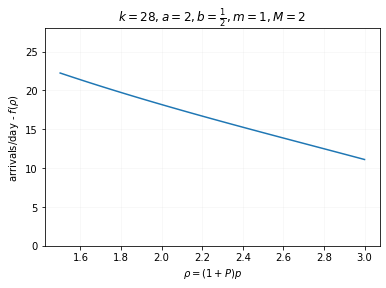

In [116]:
P = 0.5
def f_rho(rho, **kwargs):
    # lets just take P=0.5 in rho=(1+P)p
    p = rho / (1+P)
    return f(p=p, P=P, **kwargs)

# Plot a function dependant on rho
rhosP05 = [pi*(1+P) for pi in p]
plt.plot(rhosP05, [f_rho(rho=rho, k=k, m=m, M=M) for rho in rhosP05])
plt.ylim(0,28)
plt.xlabel('$\\rho=(1+P)p$')
plt.grid(alpha=0.1)
plt.ylabel('arrivals/day - $f(\\rho)$')
plt.title('$k=28, a=2, b=\\frac{1}{2}, m=1, M=2$');

## How to select $k$?

In equation (1) $k$ is the constant that scales the arrival rate. Therefore we must decide which value it takes (so as $a,b$).

We select $k$ so it follows [TID] arrival rates when the user price $\rho\in[m,2M]$ is in the middle, i.e, when $\frac{\rho-m}{2M-m}=0.5$.

For example, *t3a.small* instances have an arrival rate of 25 instances/day. Then, we generate *t3a.small* instances with an arrival rate $k$ such that $f(\rho=\frac{2M+m}{2})=25$.

Lets plot how it all looks with such a $k$:

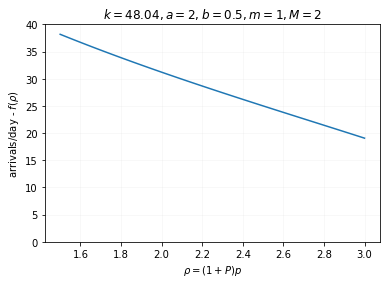

In [115]:
# Compute k
rho0 = (2*M+m)/2
k0 = (25 * (1 + (rho0-m)/(2*M-m))) / (1 - (rho0/(2*M))**a)**b

# Plot arrivals with computed k
plt.plot([(1+0.5)*pi for pi in p], [f(p=pi, P=0.5, k=k0, m=1, M=2) for pi in p])
plt.grid(alpha=0.1)
plt.ylim(0,40)
plt.xlabel('$\\rho=(1+P)p$')
plt.ylabel('arrivals/day - $f(\\rho)$');
plt.title(f'$k={k0:.2f}, a=2, b=0.5, m=1, M=2$');

## What if we change $a,b$?

A higher $b$, results in a higher decay rate.

A higher $a$, results in lower decay.

Lets create multiple plots to check the behaviour:

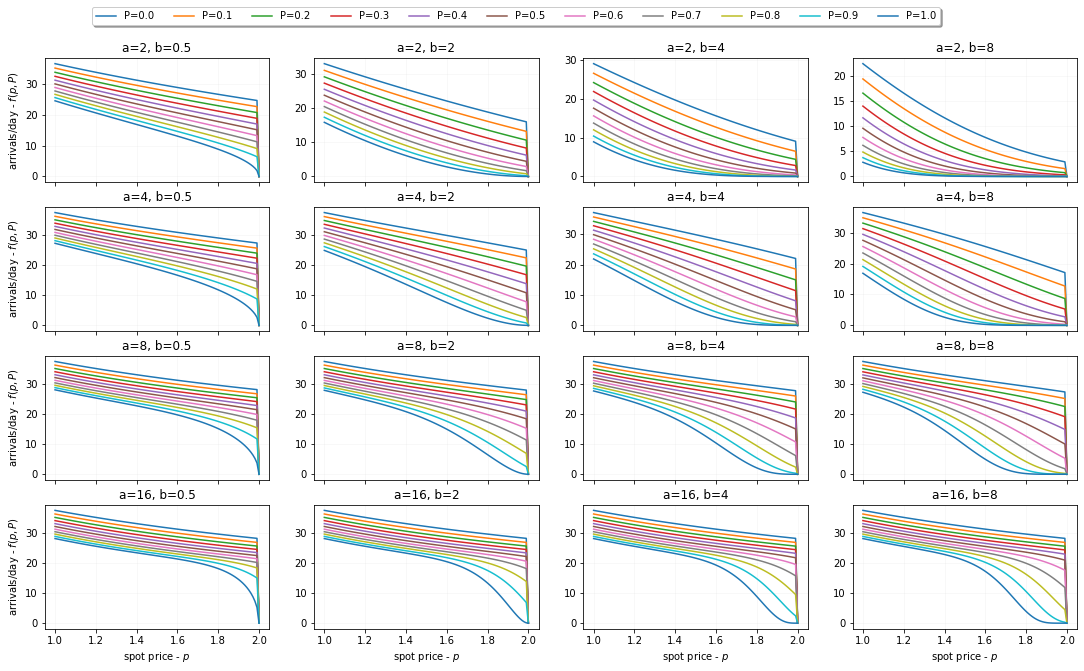

In [99]:
fig, axs = plt.subplots(4, 4, sharex=True)

# Change a and b
aidx=0
for a in [2, 4, 8, 16]:
    bidx = 0
    for b in [0.5, 2, 4, 8]:
        for P in [i/10 for i in range(11)]:
            axs[aidx, bidx].plot(p, [f(pi, P=P, k=k0, m=m, M=M, a=a, b=b) for pi in p], label=f'P={P:.1f}')
            axs[aidx, bidx].set_title(f'a={a}, b={b}')
            axs[aidx, bidx].grid(alpha=0.1)
            if aidx == 3:
                axs[aidx, bidx].set_xlabel('spot price - $p$')
            if bidx == 0:
                axs[aidx, bidx].set_ylabel('arrivals/day - $f(p,P)$')
        bidx += 1
    aidx += 1

# Save figure in tmp directory
fig.set_size_inches(18.5, 10.5)
plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 5.05),
          fancybox=True, shadow=True, ncol=11)
#plt.savefig('/tmp/ab-changes.eps', metadata='eps')
plt.show()

## References
[16] G. George, R. Wolski, C. Krintz, and J. Brevik, “Analyzing aws spotinstance  pricing,”  in 2019 IEEE International Conference on Cloud Engineering (IC2E).    IEEE, 2019, pp. 222–228

[TID] Solano, Alberto, and Luis M. Contreras. "Information Exchange to Support Multi-Domain Slice Service Provision for 5G/NFV." 2020 IFIP Networking Conference (Networking). IEEE, 2020.